# Black Friday Sales Dataset (Analytics Vidhya contest)

### Problem statement
To understand the customer purchase behavior (specifically, purchase amount) against various products of different categories, and build a model to predict the purchase amount of customer against various products which will help to create personalized offer for customers against different products.

### Attribute information
1. User_ID: User ID
2. Product_ID: Product ID
3. Gender: Sex of User
4. Age: Age in bins
5. Occupation: Occupation (Masked)
6. City_Category:	Category of the City (A,B,C)
7. Stay_In_Current_City_Years:	Number of years stay in current city
8. Marital_Status:	Marital Status
9. Product_Category_1:	Product Category (Masked)
10. Product_Category_2:	Product may belongs to other category also (Masked)
11. Product_Category_3:	Product may belongs to other category also (Masked)
12. Purchase:	Purchase Amount (Target Variable)

### Result
- The purchase prediction with a RMSE score = 2429.7891689172
- **Rank 20 out of 13791 participants (0.14%)** --*Last update: 2018-12-31*
- Leaderboard: https://datahack.analyticsvidhya.com/contest/black-friday/lb

### Reference
1. https://datahack.analyticsvidhya.com/contest/black-friday/
<br>
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, ELU, Dropout, Embedding, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
## Derive the id from the google drive shareable link
train_id = '1LeuBB1HfNzOIir6nOmipTdsKvSpKSa63'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'

## Re-generate the CSV URL
train_csv_loc=link.format(FILE_ID=train_id)
train = pd.read_csv(train_csv_loc)

## The dataset structure

In [3]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


### Note
- Data is more than half of a million, containing both object and numeric values
- Some columns could be convert to numeric for better processing (e.g. Product_ID, Age, Stay_In_Current_City_Years, etc.)
- Product_Category_2 and Product_Category_3 have missing values that should be dealt with before performing the training
***

## Exploratory feature analysis

In [5]:
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [6]:
train['Age'].value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

### Note
- Male count is roughly 3x as much as the Female count, but the mean purchase amount is about the same level as Female
- People with ages between 26-35 are the primarly customers, following by the groups of 18-25 and 36-45.
***

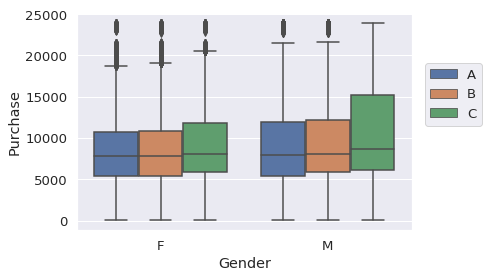

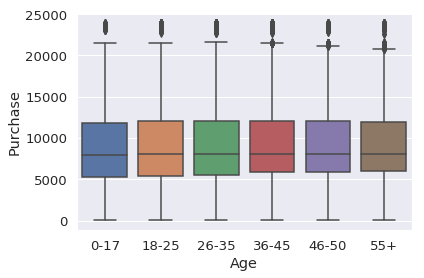

In [7]:
sns.set(font_scale=1.2)
sns.boxplot(x='Gender', y='Purchase', data=train,
            hue='City_Category', hue_order=['A','B','C'])
plt.legend(bbox_to_anchor=(1.02, 0.8))
plt.show()

sns.boxplot(x='Age', y='Purchase', data=train,
            order=['0-17','18-25','26-35','36-45','46-50','55+'])
plt.show()

### Note
- For all cities, the pruchase distributions are skewed to the bottom, which Female data appear to have higher purchase amounts that are far away from the majority, i.e. outliers. 
- **Age distribution is irrelevant to the purchase.**
***

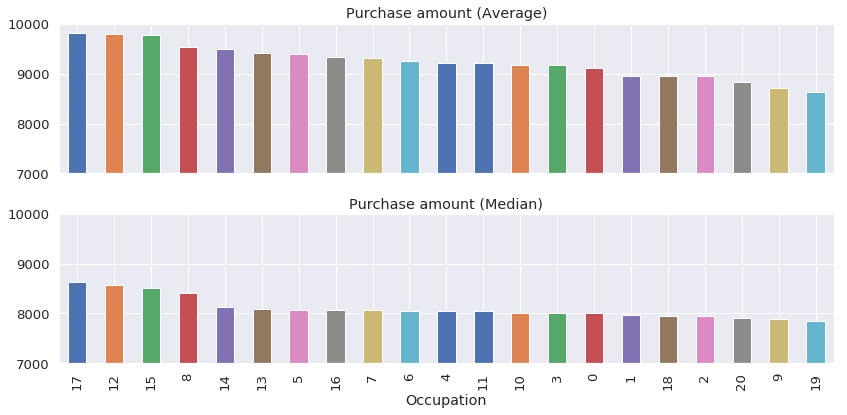

In [8]:
fig, axes = plt.subplots(2,1, sharex=True)
train.groupby(['Occupation'])['Purchase'].mean().sort_values(ascending=False).plot.bar(figsize=(12, 6), ax=axes[0])
train.groupby(['Occupation'])['Purchase'].median().sort_values(ascending=False).plot.bar(figsize=(12, 6), ax=axes[1])
axes[0].set_title('Purchase amount (Average)')
axes[0].set_ylim((7000, 10000))
axes[1].set_title('Purchase amount (Median)')
axes[1].set_ylim((7000, 10000))
plt.tight_layout()
plt.show()

### Note
- Ocupation# 17, 12, 15 have the top 3 purchase amount, and 9, 19, 20 are the bottom 3
- However, occupation does not provide a significant distinction for purchase behavior.
***

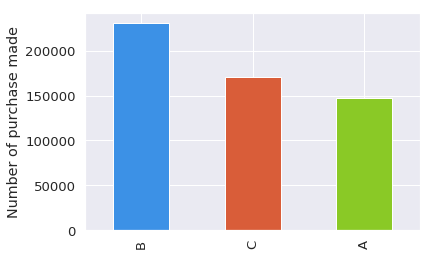

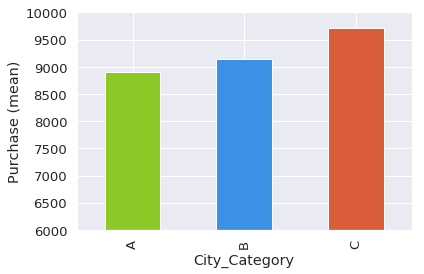

In [9]:
train['City_Category'].value_counts().plot.bar(color=['#3C91E6','#D95D39','#8AC926'])
plt.ylabel('Number of purchase made')
plt.show()

train.groupby(['City_Category'])['Purchase'].mean().plot.bar(color=['#8AC926','#3C91E6','#D95D39'])
plt.ylabel('Purchase (mean)')
plt.ylim((6000, 10000))
plt.show()

### Note
- City B appears to have highest purchase count.
- However, city B does not have the top purchase amount, suggesting **that consumer behavior is actually the small quantities with frequent purchase.**
- On the other hand, city C makes the overall largest average purchase amount.
***

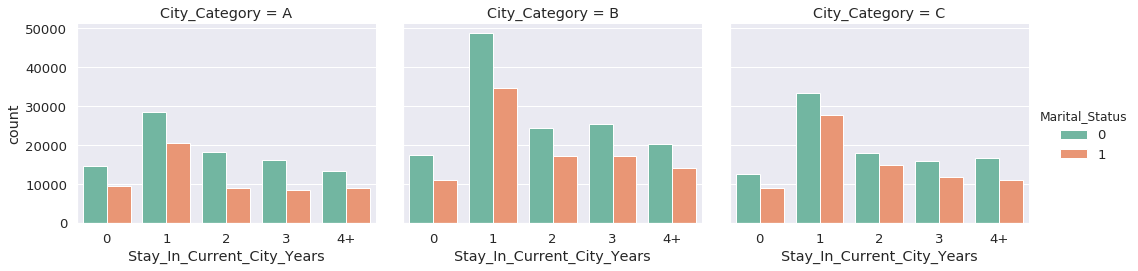

In [10]:
sns.catplot(x='Stay_In_Current_City_Years', order=['0','1','2','3','4+'],
            col='City_Category', col_order=['A','B','C'], hue='Marital_Status', 
            data=train, kind='count', palette='Set2',
            height=4, aspect=1.2)

plt.show()

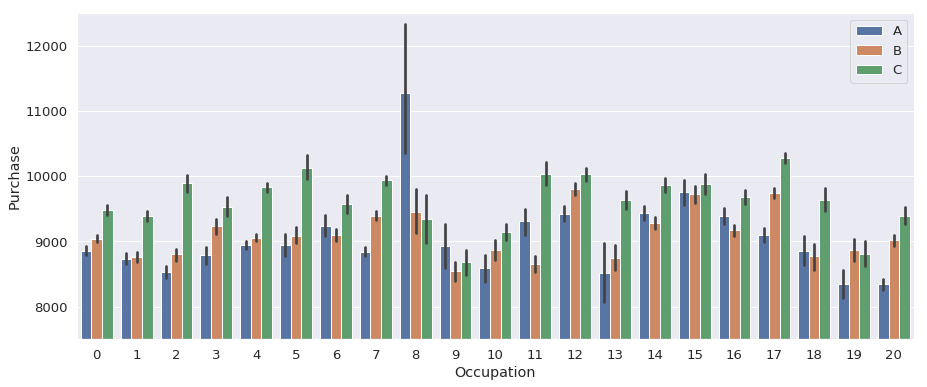

In [11]:
plt.figure(figsize=(15,6))
sns.barplot(x='Occupation', y='Purchase', data=train,
            hue='City_Category', hue_order=['A','B','C'],)
plt.ylim((7500,12500))
plt.legend(loc='best')
plt.show()

#### Note
- Most people have only been staying in the current citiy for about 1 year.
- Single people make more purchase than married people.
- Occupation does not seem to provide a clear trend, except that **#8 in A city is very different than others.**
***

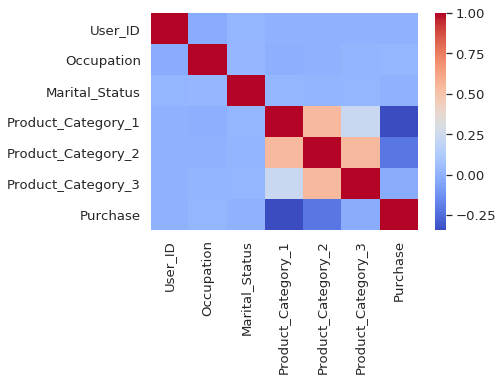

In [12]:
sns.heatmap(train.corr(), cmap='coolwarm')

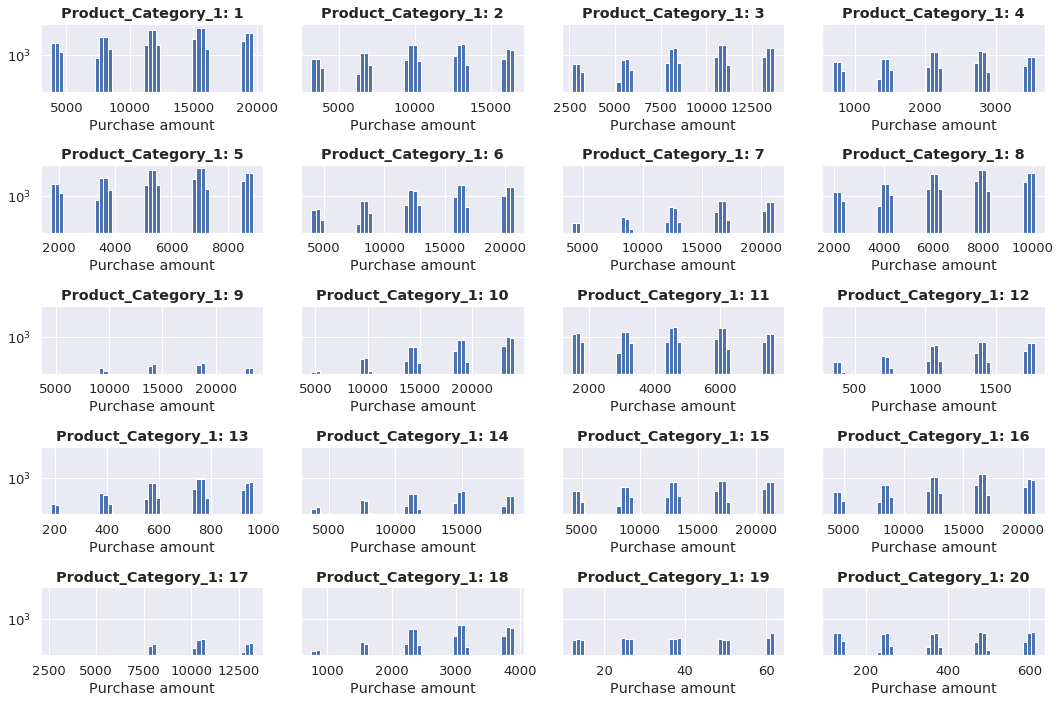

In [13]:
figs, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,10), sharey=True)
pc1 = sorted(train['Product_Category_1'].unique())
m = 0

for row in range(5):
    for col in range(4):
        axes[row,col].hist(train.loc[train['Product_Category_1']==pc1[m],'Purchase'], bins=50)
        axes[row,col].set_title('Product_Category_1: {}'.format(pc1[m]), weight='bold')
        axes[row,col].set_xlabel('Purchase amount')
        axes[row,col].set_yscale('log')
        m += 1
        
plt.tight_layout()
plt.show()

### Note
- From heatmap we can see that most of the features are not strongly correlated. 
- By looking at the histagrm of different product codes in Product_Category_1 (noted that scales in x-axis are all different), it is clearly seen that we got commonly **5 groups of purchase amount!** 
- However, there is no simple way to separate them based on other product details nor the customer demographics as shown above.
***

## Feature engineering

- Convert columns with categorical variables into numeric values, e.g. Gender, Years, Ages, etc.
- Handle missing valus in Product_Category_1/2/3
- OneHot encoded the City_Category
- Prepare nominal variables such as User_ID and Product_ID City_Category for Embedding

In [14]:
## Convert Product_ID to numeric in preparation for EmbeddingMapping
train['Product_ID'] = train['Product_ID'].apply(lambda x: int(x[1:]))

train['Gender'] = train['Gender'].apply(lambda x: 1 if x=='M' else 0)
train.rename(columns = {'Gender': 'Male'}, inplace=True)
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].apply(lambda x: int(x) if x in ['0','1','2','3'] else 5)

age_dict = {'0-17':  1,
            '18-25': 3,
            '26-35': 4,
            '36-45': 5,
            '46-50': 6,
            '51-55': 7,
            '55+':   9}

def age_num_conv(age):
    if age in age_dict:
        return age_dict[age]
    else: None
    
train['Age'] = train['Age'].apply(age_num_conv)
train[['Product_Category_1','Product_Category_2','Product_Category_3']] = train[['Product_Category_1','Product_Category_2','Product_Category_3']].applymap(lambda x: 0 if np.isnan(x) else x)

temp_city = pd.get_dummies(train['City_Category'], drop_first=True)
train = pd.concat([train, temp_city], axis=1)


In [15]:
train.head()

,User_ID,Product_ID,Male,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,B,C
0,1000001,69042,0,1,10,A,2,0,3,0.0,0.0,8370,0,0
1,1000001,248942,0,1,10,A,2,0,1,6.0,14.0,15200,0,0
2,1000001,87842,0,1,10,A,2,0,12,0.0,0.0,1422,0,0
3,1000001,85442,0,1,10,A,2,0,12,14.0,0.0,1057,0,0
4,1000002,285442,1,9,16,C,5,0,8,0.0,0.0,7969,0,1


## Neural Network

In [16]:
train = train.sample(frac=1)

In [17]:
X_train_main = train.drop(['User_ID','Product_ID','Occupation','City_Category',
                           'Product_Category_1','Product_Category_2','Product_Category_3',
                           'Purchase'], axis=1)

embd_list = ['User_ID','Product_ID','Occupation','Product_Category_1','Product_Category_2','Product_Category_3']
X_train_embd = train[embd_list]

X_train_cat = train[['User_ID']]
X_train_cat2 = train[['Product_ID']]
X_train_cat3 = train[['Occupation']]
X_train_pc1 = train[['Product_Category_1']]
X_train_pc2 = train[['Product_Category_2']]
X_train_pc3 = train[['Product_Category_3']]
y_train = train[['Purchase']]

In [18]:
X_train_embd.head()

,User_ID,Product_ID,Occupation,Product_Category_1,Product_Category_2,Product_Category_3
277301,1000770,249542,4,1,5.0,15.0
229040,1005322,350442,17,2,3.0,15.0
14522,1002155,184742,10,11,16.0,0.0
472279,1000780,115842,17,16,0.0,0.0
47138,1001246,120642,4,5,0.0,0.0


### 1. Prepare Embedding for columns with categorical variables

In [19]:
class EmbeddingMapping:
    def __init__(self, column):
        values = column.unique().tolist()
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        self.num_values = len(values)+1

    def get_mapping(self, value):
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        else:
            return self.num_values

In [20]:
user_id_mapping = EmbeddingMapping(X_train_cat['User_ID'])
X_train_cat = X_train_cat.assign(user_id_mapping=X_train_cat['User_ID'].apply(user_id_mapping.get_mapping)).drop('User_ID', axis=1)

product_id_mapping = EmbeddingMapping(X_train_cat2['Product_ID'])
X_train_cat2 = X_train_cat2.assign(product_id_mapping=X_train_cat2['Product_ID'].apply(product_id_mapping.get_mapping)).drop('Product_ID', axis=1)

occ_mapping = EmbeddingMapping(X_train_cat3['Occupation'])
X_train_cat3 = X_train_cat3.assign(occ_mapping=X_train_cat3['Occupation'].apply(occ_mapping.get_mapping)).drop('Occupation', axis=1)

pc1_mapping = EmbeddingMapping(X_train_pc1['Product_Category_1'])
X_train_pc1 = X_train_pc1.assign(pc1_mapping=X_train_pc1['Product_Category_1'].apply(pc1_mapping.get_mapping)).drop('Product_Category_1', axis=1)

pc2_mapping = EmbeddingMapping(X_train_pc2['Product_Category_2'])
X_train_pc2 = X_train_pc2.assign(pc2_mapping=X_train_pc2['Product_Category_2'].apply(pc2_mapping.get_mapping)).drop('Product_Category_2', axis=1)

pc3_mapping = EmbeddingMapping(X_train_pc3['Product_Category_3'])
X_train_pc3 = X_train_pc3.assign(pc3_mapping=X_train_pc3['Product_Category_3'].apply(pc3_mapping.get_mapping)).drop('Product_Category_3', axis=1)


### 2. Build the model

In [21]:
def model_embd(main, cat1, cat2, cat3, pc1, pc2, pc3):
    data_main = main
    data_cat1 = cat1
    data_cat2 = cat2
    data_cat3 = cat3
    data_pc1 = pc1
    data_pc2 = pc2
    data_pc3 = pc3
    
    id_input1 = Input(shape=(data_cat1.shape[1],), dtype='int32', name='id_input1')
    x1 = Embedding(output_dim=32, input_dim=5892, input_length=len(data_cat1))(id_input1)
    id_out1 = Flatten()(x1)

    id_input2 = Input(shape=(data_cat2.shape[1],), dtype='int32', name='id_input2')
    x2 = Embedding(output_dim=32, input_dim=3633, input_length=len(data_cat2))(id_input2)
    id_out2 = Flatten()(x2)
    
    id_input3 = Input(shape=(data_cat3.shape[1],), dtype='int32', name='id_input3')
    x3 = Embedding(output_dim=2, input_dim=22, input_length=len(data_cat3))(id_input3)
    id_out3 = Flatten()(x3)
    
    id_input4 = Input(shape=(data_pc1.shape[1],), dtype='int32', name='id_input4')
    x4 = Embedding(output_dim=4, input_dim=22, input_length=len(data_pc1))(id_input4)
    id_out4 = Flatten()(x4)
    
    id_input5 = Input(shape=(data_pc2.shape[1],), dtype='int32', name='id_input5')
    x5 = Embedding(output_dim=4, input_dim=20, input_length=len(data_pc2))(id_input5)
    id_out5 = Flatten()(x5)
    
    id_input6 = Input(shape=(data_pc3.shape[1],), dtype='int32', name='id_input6')
    x6 = Embedding(output_dim=4, input_dim=18, input_length=len(data_pc3))(id_input6)
    id_out6 = Flatten()(x6)

    main_input = Input(shape=(data_main.shape[1],), name='main_input')
    main_layer0 = keras.layers.concatenate([main_input, id_out1, id_out2, id_out3, id_out4, id_out5, id_out6])
    main_layer0 = BatchNormalization()(main_layer0)
    main_layer1 = Dense(36, activation="elu")(main_layer0)
    main_layer1 = BatchNormalization()(main_layer1)
    main_layer2 = Dense(36, activation="elu")(main_layer1)
    main_layer2 = BatchNormalization()(main_layer2)
    main_layer3 = Dense(36, activation="elu")(main_layer2)
    main_layer3 = BatchNormalization()(main_layer3)
    main_output = Dense(1, name='main_output')(main_layer3)

    model = Model(inputs=[main_input,id_input1, id_input2, id_input3, id_input4, id_input5, id_input6], 
                  outputs=[main_output])

    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['mse'])
                           
    return model

In [22]:
model = model_embd(X_train_main, 
                   X_train_cat, X_train_cat2, X_train_cat3,
                   X_train_pc1, X_train_pc2, X_train_pc3)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id_input1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input3 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input4 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
id_input5 

### 3. Setting callbcaks

In [23]:
early_stopping = EarlyStopping(patience=5)

filepath='model-{epoch:02d}-{val_mean_squared_error:.2f}.hdf5'
check_point = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=0, save_best_only=True)

### 4. Model fit

In [24]:
EPOCHS = 100
# with tf.device("/gpu:0"):

history = model.fit([X_train_main, X_train_cat, X_train_cat2, X_train_cat3, X_train_pc1, X_train_pc2, X_train_pc3], 
                     y_train,
                     epochs=EPOCHS,
                     validation_split = 0.3,
                     verbose=1, shuffle=True,
                     callbacks=[early_stopping]) #check_point])


Train on 385047 samples, validate on 165021 samples
Epoch 1/100
385047/385047 [==============================] - 52s 134us/step - loss: 63447696.2294 - mean_squared_error: 63447696.2294 - val_loss: 14660273.8395 - val_mean_squared_error: 14660273.8395
Epoch 2/100
385047/385047 [==============================] - 51s 132us/step - loss: 7604904.3573 - mean_squared_error: 7604904.3573 - val_loss: 6076227.5896 - val_mean_squared_error: 6076227.5896
Epoch 3/100
385047/385047 [==============================] - 50s 131us/step - loss: 6405670.8912 - mean_squared_error: 6405670.8912 - val_loss: 5959228.3104 - val_mean_squared_error: 5959228.3104
Epoch 4/100
385047/385047 [==============================] - 50s 131us/step - loss: 6192145.2539 - mean_squared_error: 6192145.2539 - val_loss: 5905874.1244 - val_mean_squared_error: 5905874.1244
Epoch 5/100
385047/385047 [==============================] - 50s 131us/step - loss: 6032895.9063 - mean_squared_error: 6032895.9063 - val_loss: 5908228.2716 - v

### Output the best RMSE obtained during training in the cross-valication 

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['RMSE'] = np.sqrt(hist['mean_squared_error'])
hist['val_RMSE'] = np.sqrt(hist['val_mean_squared_error'])
hist.loc[[hist['val_RMSE'].idxmin()]][['val_mean_squared_error' ,'val_RMSE']]

,val_mean_squared_error,val_RMSE
5,5.904382e+06,2429.893509


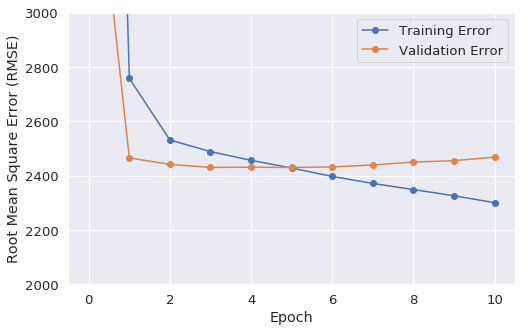

In [26]:
plt.figure(figsize=(8,5))

plt.plot(hist['epoch'], hist['RMSE'], '-o',
         label='Training Error')
plt.plot(hist['epoch'], hist['val_RMSE'], '-o',
         label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.ylim(2000, 3000)
plt.legend()
plt.show()


### End of document